In [1]:
# this is specific to macos X , windows/linux users dont need this 
# without this , while using xgboost , you get errors , kernel dies
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import math as mt

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
from keras.models import Model,Sequential
from keras.layers import Dense,Input

Using TensorFlow backend.


In [6]:
from rfpimp import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

## Coding categorical features as dummies 

In [7]:
def code_categorical_to_dummies(dt,columns,freq_cutoff=0):
    data=dt.copy()
    for col in columns:
        
        freq_table=data[col].value_counts(dropna=False)
        
        if (freq_table<freq_cutoff).sum()==0:
            cats=freq_table.index[:-1]
        else:
            cats=freq_table.index[freq_table>freq_cutoff]
        
        for cat in cats:
            data[col+'_'+str(cat)]=(data[col]==cat).astype(int)
        
        del data[col]
        
        
    return data

### Pipeline friendly class

In [ ]:
class get_dummies_Pipe(BaseEstimator, TransformerMixin):
    
    def __init__(self,freq_cutoff=0):
        self.freq_cutoff=freq_cutoff
        self.var_cat_dict={}
        
    def fit(self,x,y=None):
        data_cols=x.columns
        for col in data_cols:
            freq_table=x[col].value_counts(dropna=False)
            if (freq_table<self.freq_cutoff).sum()==0:
                cats=freq_table.index[:-1]
            else:
                cats=freq_table.index[freq_table>self.freq_cutoff]
            self.var_cat_dict[col]=cats
        return self
            
    def transform(self,x,y=None):
        dummy_data=x.copy()
        for col in self.var_cat_dict.keys():
            for cat in self.var_cat_dict[col]:
                name=col+'_'+str(cat)
                dummy_data[name]=(dummy_data[col]==cat).astype(int)
            del dummy_data[col]
        return dummy_data

In [ ]:
d1=pd.DataFrame({'x':['a','b','a','b','c','c']})
d2=pd.DataFrame({'x':['a','b','a','b','c','c','d','d','d']})

In [ ]:
code_categorical_to_dummies(d1,'x')

In [ ]:
code_categorical_to_dummies(d2,'x')

In [ ]:
gd=get_dummies_Pipe()

In [ ]:
gd.fit(d1)

In [ ]:
gd.var_cat_dict

In [ ]:
gd.transform(d1)

In [ ]:
gd.transform(d2)

## Categorical Embeddings

In [9]:

file = r'/Users/lalitsachan/Dropbox/0.0 Data/loans data.csv'
data=pd.read_csv(file)
data['State'].nunique()

47

In [ ]:
dummy_data=pd.get_dummies(data['State'],prefix='State')
dummy_data.shape[1]

In [ ]:
y=dummy_data

In [ ]:
data['State'].nunique()

In [ ]:
y.shape

In [ ]:
embedding_dim=3

inputs=Input(shape=(dummy_data.shape[1],))

dense1=Dense(20,activation='relu')(inputs)

embedded_output=Dense(embedding_dim)(dense1)

outputs=Dense(dummy_data.shape[1],activation='softmax')(embedded_output)
model=Model(inputs=inputs,outputs=outputs)

embedder=Model(inputs=inputs,outputs=embedded_output)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(dummy_data,y,epochs=150,batch_size=100)

In [ ]:
low_dim=pd.DataFrame(embedder.predict(dummy_data),columns=['emb1','emb2','emb3'])
low_dim.head()

In [ ]:
low_dim

In [ ]:
data['State']

## Coding cyclic time features 

In [ ]:
import numpy as np

In [ ]:
months=np.arange(1,13)
months

In [ ]:
months_sin=np.sin(2*np.pi*months/12)

In [ ]:
sns.scatterplot(months,months_sin).plot()

In [ ]:
months_cos=np.cos(2*np.pi*months/12)

In [ ]:
sns.scatterplot(months_sin,months_cos).plot()

In [ ]:
def code_cyclic_features(data,columns,drop_cols=True):
    for col in columns:
        max_val=max(data[col])

        data[col+'_sin']=np.sin(2*np.pi*data[col]/max_val)
        data[col+'_cos']=np.cos(2*np.pi*data[col]/max_val)

        if drop_cols:
            del data[col]
    return data  

## Revisiting feature importance and issue with default importance in sklearn

In [10]:
data.head()

,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,81174.0,20000,20000,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14,14272,2.0,< 1 year
1,99592.0,19200,19200,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12,11140,1.0,2 years
2,80059.0,35000,35000,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14,21977,1.0,2 years
3,15825.0,10000,9975,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10,9346,0.0,5 years
4,33182.0,12000,12000,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11,14469,0.0,9 years


In [11]:
data.drop(['ID','Amount.Funded.By.Investors'],axis=1,inplace=True)

for col in ['Interest.Rate','Debt.To.Income.Ratio']:
    data[col]=data[col].str.replace("%","")
    
    

for col in ['Amount.Requested', 'Interest.Rate','Debt.To.Income.Ratio',
            'Open.CREDIT.Lines','Revolving.CREDIT.Balance']:
    data[col]=pd.to_numeric(data[col],errors='coerce')
    

k=data['FICO.Range'].str.split("-",expand=True).astype(float)

data['fico']=0.5*(k[0]+k[1])

del data['FICO.Range']

cat_cols=data.select_dtypes(['object']).columns

data=code_categorical_to_dummies(data,cat_cols)

for col in data.columns:
    if data[col].isnull().sum()>0:
        data.loc[data[col].isnull(),col]=data[col].mean()

In [12]:
x_train=data.drop(['Interest.Rate'],1)
y_train=data['Interest.Rate']

In [13]:
x_train.shape

(2500, 88)

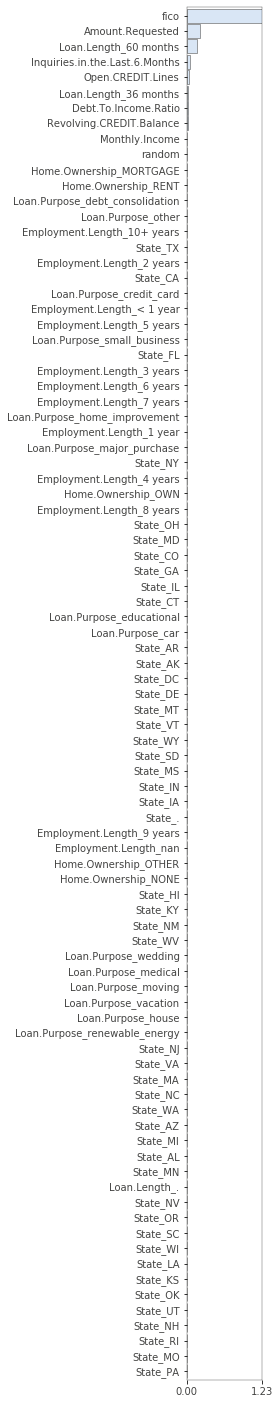

In [14]:
# Add column of random numbers
x_train['random'] = np.random.random(size=len(x_train))


rf = RandomForestRegressor(n_estimators=100,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True)

rf.fit(x_train,y_train)

imp = importances(rf, x_train, y_train, n_samples=-1) # this function comes from package rfpimp
viz = plot_importances(imp)
viz.view()

# it is possible that with different iterations of the code result in features at boundary switch to other side
# dont worry about that , they dont make much difference either way [ and you have to draw a line somewhere]

In [17]:
imp

,Importance
Feature,
fico,1.232436e+00
Amount.Requested,2.137498e-01
Loan.Length_60 months,1.631791e-01
Inquiries.in.the.Last.6.Months,5.446839e-02
Open.CREDIT.Lines,3.535306e-02
Loan.Length_36 months,2.463570e-02
Debt.To.Income.Ratio,1.614558e-02
Revolving.CREDIT.Balance,1.502112e-02
Monthly.Income,1.184924e-02


## Transformed Features : capability of algos to capture transformation automatically

In [18]:
x_data= pd.DataFrame(np.random.random(size= (4000,5)), columns= ['x1','x2','x3','x4','x5'])

x_data.shape

(4000, 5)

In [19]:
x_data['y1']= 1.5 + x_data['x1'] + x_data['x2'] + x_data['x3'] + x_data['x4'] + x_data['x5'] + np.random.random(size=4000)
x_data['y2']= 1.5 + (x_data['x1']**2) + (x_data['x2']**2) + (x_data['x3']**2) + (x_data['x4']**2) + (x_data['x5']**2) + np.random.random(size=4000)
x_data['y3']= 1.5 + (np.log(x_data['x1'])) + (np.log(x_data['x2'])) + (np.log(x_data['x3'])) + (np.log(x_data['x4'])) + (np.log(x_data['x5'])) + np.random.random(size=4000)
x_data['y4']= 1.5 + (1/x_data['x1']) + (1/x_data['x2']) + (1/x_data['x3']) + (1/x_data['x4']) + (1/x_data['x5']) + np.random.random(size=4000)
x_data['y5']= 1.5 + (x_data['x2']/x_data['x1'])  + (x_data['x3']/x_data['x2'])  + (x_data['x4']/x_data['x3']) + (x_data['x5']/x_data['x4']) + np.random.random(size=4000)

x_data.head(5)

,x1,x2,x3,x4,x5,y1,y2,y3,y4,y5
0,0.054447,0.623752,0.895589,0.408826,0.755968,4.372272,4.038813,-3.068748,26.529424,17.389404
1,0.376958,0.875753,0.318691,0.224617,0.158346,3.651607,3.233839,-3.992610,19.228088,6.398190
2,0.071422,0.870633,0.503284,0.123026,0.743705,4.472332,3.445294,-4.191352,28.707064,21.280835
3,0.616888,0.458903,0.492146,0.429634,0.416131,4.029798,2.856972,-2.138592,12.126164,6.145435
4,0.190305,0.876121,0.171896,0.174805,0.763683,3.800867,3.793198,-3.289730,21.713400,12.619647


In [20]:

train, test= train_test_split(x_data, test_size= 0.2, random_state=2)

x_train= train.drop(['y1','y2','y3','y4','y5'],1)
y_train= train[['y1','y2','y3','y4','y5']]

x_test= test.drop(['y1','y2','y3','y4','y5'],1)
y_test= test[['y1','y2','y3','y4','y5']]

results= pd.DataFrame(columns=["Algo","Relation","MAE"])

In [21]:
def Random_Forest(x,y,relation):
    rf= RandomForestRegressor(n_estimators=200)
    rf.fit(x,y_train[y])
    y_pred=rf.predict(x_test)
    mae= np.round(mean_absolute_error(y_test[y],y_pred),4)
    global results
    results= results.append({'Algo':"Random Forest",'Relation':relation,'MAE':mae}, ignore_index=True)
    
    #return(print("Algo: Random Forest\nRelation: "+relation+" \nMean Absolute error: ",mean_absolute_error(y_test[y],y_pred)))
    

def SV_M (x,y, relation):
    svr= SVR()
    svr.fit(x,y_train[y])
    y_pred=svr.predict(x_test)
    mae= np.round(mean_absolute_error(y_test[y],y_pred),4)
    global results
    results= results.append({'Algo':"SVM",'Relation':relation,'MAE':mae}, ignore_index=True)
   # return(print("Algo: SVM \nRelation: "+relation+" \nMean Absolute error: ",mean_absolute_error(y_test[y],y_pred)))

def XG_B(x,y, relation):
    xgb= XGBRegressor(n_estimators=200,learning_rate=.01,objective='reg:squarederror')
    xgb.fit(x,y_train[y])
    y_pred=xgb.predict(x_test)
    mae= np.round(mean_absolute_error(y_test[y],y_pred),4)
    global results
    results= results.append({'Algo':"XGB",'Relation':relation,'MAE':mae}, ignore_index=True)
   # return(print("Algo: XGB \nRelation: "+relation+" \nMean Absolute error: ",mean_absolute_error(y_test[y],y_pred)))

In [22]:
# SET-1 (x)

Random_Forest(x_train,"y1","x")

SV_M(x_train,"y1","x")

XG_B(x_train,"y1","x")

In [23]:
# SET-2 (x^2)

Random_Forest(x_train,"y2","x^2")

SV_M(x_train,"y2","x^2")

XG_B(x_train,"y2","x^2")



In [24]:
# SET-3 (log(x))
Random_Forest(x_train,"y3","log(x)")

SV_M(x_train,"y3","log(x)")

XG_B(x_train,"y3","log(x)")



In [25]:
# SET-4 (Inverse)
Random_Forest(x_train,"y4","1/x")

SV_M(x_train,"y4","1/x")

XG_B(x_train,"y4","1/x")

In [26]:
# SET-5 (Ratios)

Random_Forest(x_train,"y5","Ratio")

SV_M(x_train,"y5","Ratio")

XG_B(x_train,"y5","Ratio")

In [27]:
results

,Algo,Relation,MAE
0,Random Forest,x,0.2689
1,SVM,x,0.2579
2,XGB,x,0.5714
3,Random Forest,x^2,0.2656
4,SVM,x^2,0.2483
5,XGB,x^2,0.4848
6,Random Forest,log(x),0.4083
7,SVM,log(x),0.5673
8,XGB,log(x),0.9426
9,Random Forest,1/x,5.3361
